In [38]:
import pandas as pd
import graph_tool.all as gt
import networkx as nx
import numpy as np
import requests

In [2]:
import pickle

In [4]:
g = gt.load_graph('../data/biobanks.graphml')

pos = g.new_vp('vector<double>')

for v in g.iter_vertices():
    pos[v] = (g.vp['x'][v], g.vp['y'][v])

h = gt.GraphView(g, vfilt=gt.label_largest_component(g))

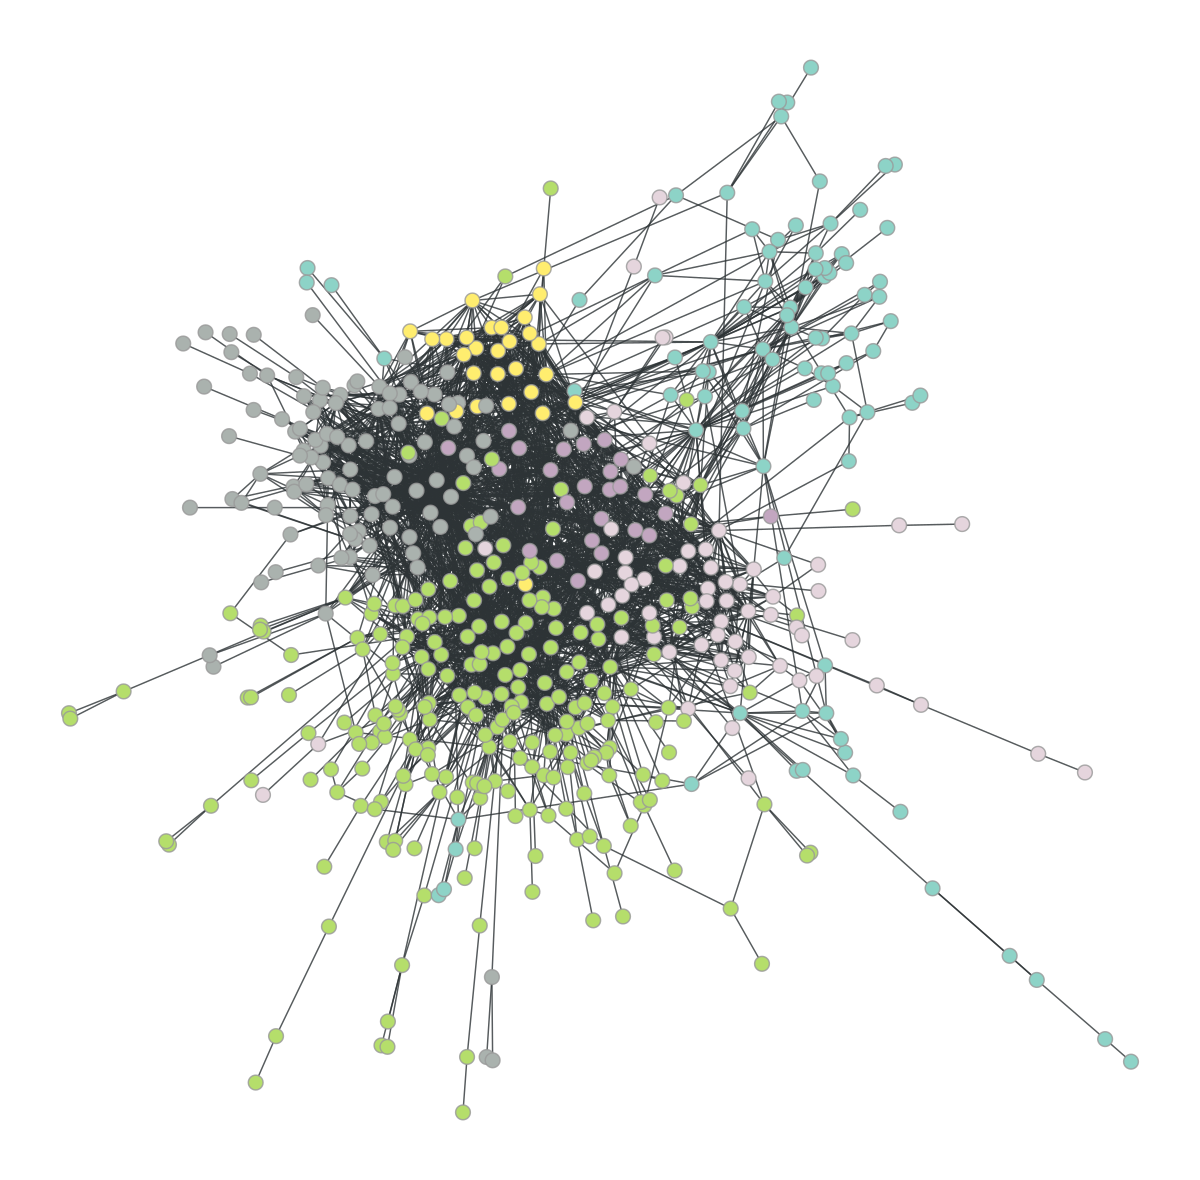

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x18f07e460, at 0x18efc2850>

In [5]:
gt.graph_draw(h, pos=pos, vertex_fill_color=g.vp['block'])

# Elements

In order to map the network to Dash Cytoscape we need a list of nodes and edges.

Each node should contain:

1. Id (the id of the node)
2. label to be displayed
3. Position

Edges should contain:

1. Source
2. Target
3. Label

In [6]:
ids = g.vp['label']

In [7]:
ids[0]

'ART-LINC'

In [8]:
g.ep['weight']

<EdgePropertyMap object with value type 'long double', for Graph 0x18efc22e0, at 0x18f07e2e0>

In [9]:
nodes = []
for v in h.iter_vertices():
    data = {'id': str(v), 'label': ids[v], 'size': g.vp['citations'][v]}
    position = {'x': g.vp['x'][v], 'y': g.vp['y'][v]}
    block = g.vp['block'][v]
    _class = ''
    if block == 18:
        _class = 'general'
    if block == 75:
        _class = 'birth'
    if block == 125:
        _class = 'health'
    if block == 93:
        _class = 'british'
    if block == 60:
        _class = 'middle'
    if block == 120:
        _class = 'aging'
    nodes.append({'data': data, 'position': position, 'classes': _class})

edges = []
for e in h.iter_edges():
    u, v = g.vertex(e[0]), g.vertex(e[1])
    data = {'source': str(e[0]), 'target': str(e[1]), 'label': f'Node {e[0]} to {e[1]}',
            'weight': g.ep['weight'][g.edge(u, v)]}
    edges.append({'data': data})

elements = nodes + edges

In [112]:
with open('../data/elements.p', 'wb') as f:
    pickle.dump(elements, f)

## Stylesheet

In [10]:
stylesheet = [
    {'selector': 'node',
        'style': {
            'content': 'data(label)',
            "width": "mapData(size, 0, 500, 5, 60)",
            "height": "mapData(size, 0, 500, 5, 60)",
            "font-size": "20px"
                }
            },
    {'selector': 'edge',
        'style': {
            "width": "mapData(weight, 1, 10, 0.3, 15)",
                }
            },
    {'selector': '.general',
        'style': {
            'background-color': '#8e82c6',
            'line-color': '#8e82c6'}
    },
    {'selector': '.health',
        'style': {
            'background-color': '#6fa8dc',
            'line-color': '#6fa8dc'}
    },
    {'selector': '.middle',
        'style': {
            'background-color': '#f44336',
            'line-color': '#f44336'}
    },
    {'selector': '.aging',
        'style': {
            'background-color': '#4c1130',
            'line-color': '#4c1130'}
    },
    {'selector': '.british',
        'style': {
            'background-color': '#3C4639',
            'line-color': '#3C4639'}
    },
    {'selector': '.birth',
        'style': {
            'background-color': '#6AA84F',
            'line-color': '#6AA84F'}
    },
]

with open('../data/stylesheet.p', 'wb') as f:
    pickle.dump(stylesheet, f)

In [11]:
disease = pd.read_csv('../data/diseases_citations.csv')

/Users/r.dorantesgilardi/opt/miniconda3/envs/bb/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
disease = disease[disease['DescriptorDisease']==1]

In [13]:
team = pd.read_csv('../data/team_info.csv')

In [14]:
pis = pd.read_csv('../data/manual_cohort.csv')

In [15]:
paper2cit = dict(zip(pis['PaperId'], pis['CitationPI2']))

In [35]:
team[team['OriginalTitle'].str.contains('Million')]['CitationPI'].item()

102794.0

In [43]:
r = requests.get(f'https://api.openalex.org/authors/A{3098681172}')

In [54]:
def get_name(x):
    r = requests.get(f'https://api.openalex.org/authors/A{x}')
    if r:
        if 'display_name' in r.json():
            return r.json()['display_name']
    return 'NaN'

In [56]:
team['PIName'] = team['PI'].astype(int).apply(get_name)

In [63]:
pis['PIName'] = pis['PI'].astype(int).apply(get_name)

In [64]:
paper2pi = dict(zip(pis['PaperId'], pis['PIName']))

In [69]:
paper2year = dict(zip(pis['PaperId'], pis['Year']))

In [87]:
for v in h.iter_vertices():
    if g.vp['id'][v] not in paper2year:
        r = requests.get(f"https://api.openalex.org/works/W{g.vp['id'][v]}")
        if r:
            if "publication_year" in r.json():
                paper2year[g.vp['id'][v]] = int(r.json()["publication_year"])

In [90]:
paper2teamsize = dict()

In [91]:
for v in h.iter_vertices():  
    r = requests.get(f"https://api.openalex.org/works/W{g.vp['id'][v]}")
    if r:
        if "authorships" in r.json():
            paper2teamsize[g.vp['id'][v]] = len(r.json()["authorships"])
        else:
            paper2teamsize[g.vp['id'][v]] = 'NaN'
    else:
        paper2teamsize[g.vp['id'][v]] = 'NaN'

In [123]:
chars = dict()
chars['comm'] = dict()
chars['paper'] = dict()
chars['citations'] = dict()
chars['diseases'] = dict()
chars['main_disease'] = dict()
chars['lead'] = dict()
chars['team_size'] = dict()
chars['lead_citations'] = dict()
chars['female_proportion'] = dict()
chars['PI'] = dict()
chars['year'] = dict()
for v in h.iter_vertices():
    block = g.vp['block'][v]
    paper = g.vp['name'][v]
    chars['paper'][v] = paper
    chars['citations'][v] = g.vp['citations'][v]
    chunk = disease[disease['PaperReferenceId']==g.vp['id'][v]]
    chars['diseases'][v] = chunk['DescriptorName'].nunique()
    chunk2 = team[team['PaperId']==g.vp['id'][v]]
    if chars['diseases'][v]:
        chars['main_disease'][v] = ", ".join(chunk['DescriptorName'].value_counts().index[:3])
    else:
        chars['diseases'][v] = 'NaN'
        chars['main_disease'][v] = 'NaN'
    if chunk2.shape[0]:
        chars['team_size'][v] = chunk2['TeamSize'].iloc[0]
        if (0.4 < chunk2['FemalePropotion'].iloc[0]) and (chunk2['FemalePropotion'].iloc[0] < 0.6):
            chars['female_proportion'][v] = 'Balanced *(between 40% and 60% female)*'
        else:
            chars['female_proportion'][v] = 'Non-Balanced *(less than 40% or more than 60% female)*'
    else:
        chars['team_size'][v] = 'NaN'
        chars['female_proportion'][v] = 'NaN'
    chars['team_size'][v] = paper2teamsize[g.vp['id'][v]]
    if g.vp['id'][v] in paper2year:
        chars['year'][v] = paper2year[g.vp['id'][v]]
    else:
        chars['year'][v] = 'NaN'
    if g.vp['id'][v] in paper2pi:
        chars['PI'][v] = paper2pi[g.vp['id'][v]]
    else:
        chars['PI'][v] = 'NaN'
    if block == 18:
        chars['comm'][v] = 'Population-based'
    if block == 75:
        chars['comm'][v] = 'Birth/childhood'
    if block == 125:
        chars['comm'][v] = 'Health-based'
    if block == 93:
        chars['comm'][v] = 'British'
    if block == 60:
        chars['comm'][v] = 'Low/middle-income country'
    if block == 120:
        chars['comm'][v] = 'Aging'

with open('../data/chars.p', 'wb') as f:
    pickle.dump(chars, f)

### Save talbe with data

In [122]:
pis[['Doi', 'OriginalTitle', 'CitationCount', 'Hindex']].to_csv('../data/biobanks.csv', index=False)